In [ ]:
romf google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/archive (1).zip' -d '/content/cancerdata/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/cancerdata/data/train/benign/420.jpg  
  inflating: /content/cancerdata/data/train/benign/421.jpg  
  inflating: /content/cancerdata/data/train/benign/422.jpg  
  inflating: /content/cancerdata/data/train/benign/423.jpg  
  inflating: /content/cancerdata/data/train/benign/424.jpg  
  inflating: /content/cancerdata/data/train/benign/425.jpg  
  inflating: /content/cancerdata/data/train/benign/426.jpg  
  inflating: /content/cancerdata/data/train/benign/429.jpg  
  inflating: /content/cancerdata/data/train/benign/43.jpg  
  inflating: /content/cancerdata/data/train/benign/430.jpg  
  inflating: /content/cancerdata/data/train/benign/431.jpg  
  inflating: /content/cancerdata/data/train/benign/432.jpg  
  inflating: /content/cancerdata/data/train/benign/434.jpg  
  inflating: /content/cancerdata/data/train/benign/435.jpg  
  inflating: /content/cancerdata/data/train/benign/438.jpg  
  inflating: /content/cancerdata/da

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

In [ ]:
train_data=tf.keras.preprocessing.image_dataset_from_directory('/content/cancerdata/train',image_size=(224,224),color_mode="rgb",
    batch_size=15,
    shuffle=True,
    seed=123)
valid_data=tf.keras.preprocessing.image_dataset_from_directory('/content/cancerdata/test',image_size=(224,224),color_mode="rgb",
    batch_size=15,
    shuffle=True,
    seed=123)

Found 2637 files belonging to 2 classes.
Found 660 files belonging to 2 classes.


In [ ]:
name=train_data.class_names
name

['benign', 'malignant']

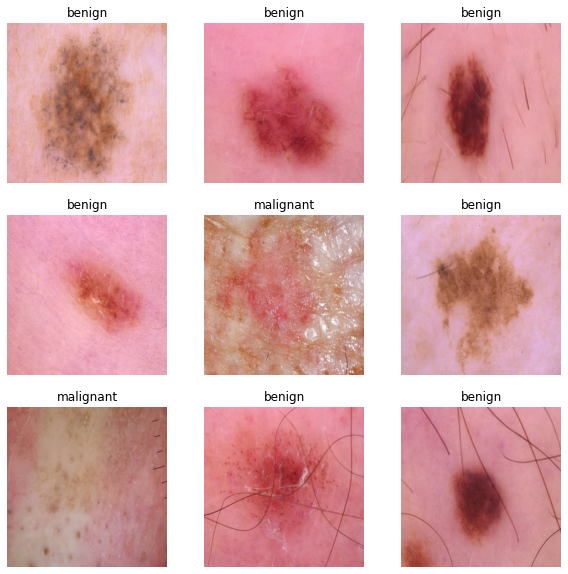

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data= train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
def conv2d_block(input_tensor,n_filters,kernel_size=3):
  x=input_tensor
  for i in range(2):
    x=tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(kernel_size,kernel_size),padding='same')(x)
    x=tf.keras.layers.Activation('relu')(x)
  return x
def encoder_block(inputs,n_filter,pool_size,dropout):
  f=conv2d_block(input_tensor=inputs,n_filters=n_filter)
  p=tf.keras.layers.MaxPooling2D(pool_size)(f)
  p=tf.keras.layers.Dropout(dropout)(p)
  return f,p
def encoder(inputs):
  f1,p1=encoder_block(inputs,n_filter=64,pool_size=(2,2),dropout=0.3)
  f2,p2=encoder_block(p1,n_filter=128,pool_size=(2,2),dropout=0.3)
  f3,p3=encoder_block(p2,n_filter=256,pool_size=(2,2),dropout=0.3)
  f4,p4=encoder_block(p3,n_filter=512,pool_size=(2,2),dropout=0.3)
  return p4,(f1,f2,f3,f4)
def bottleneck(inputs):
  bottle_neck=conv2d_block(inputs,n_filters=1024)
  return bottle_neck
def decoder_block(inputs,conv_output,n_filter,kernel_size,strides,dropout):
  u=tf.keras.layers.Conv2DTranspose(n_filter,kernel_size,strides=strides,padding='same')(inputs)
  c=tf.keras.layers.concatenate([u,conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c=conv2d_block(c,n_filter,kernel_size=3)
  return c
def decoder(inputs,convs):
  f1,f2,f3,f4=convs
  c6=decoder_block(inputs,f4,n_filter=512,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c7=decoder_block(c6,f3,n_filter=256,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c8=decoder_block(c7,f2,n_filter=128,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c9=decoder_block(c8,f1,n_filter=64,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  outputs=tf.keras.layers.Conv2D(32,kernel_size=(1,1),activation='relu')(c9)
  outputs=tf.keras.layers.Flatten()(outputs)
  outputs=tf.keras.layers.Dense(1,activation='sigmoid')(outputs)
  return outputs
def unet():
  inputs=tf.keras.layers.Input(shape=(224,224,3,))
  encoder_output,convs=encoder(inputs)
  bottle_neck=bottleneck(encoder_output)
  outputs=decoder(bottle_neck,convs)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model
def main():
  model = unet()
  model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])
  model.fit(train_data,epochs=20)
  model.save('/content/cancerDetection.h5')
  model.summary()

In [ ]:
import numpy as np
if __name__ == '__main__':
  main()

Epoch 1/20
176/176 [==============================] - 224s 1s/step - loss: 45.4862 - accuracy: 0.6576
Epoch 2/20
176/176 [==============================] - 222s 1s/step - loss: 0.4619 - accuracy: 0.7766
Epoch 3/20
176/176 [==============================] - 222s 1s/step - loss: 0.4242 - accuracy: 0.7873
Epoch 4/20
176/176 [==============================] - 222s 1s/step - loss: 0.3987 - accuracy: 0.7952
Epoch 5/20
176/176 [==============================] - 222s 1s/step - loss: 0.3820 - accuracy: 0.8036
Epoch 6/20
176/176 [==============================] - 222s 1s/step - loss: 0.3845 - accuracy: 0.7964
Epoch 7/20
176/176 [==============================] - 222s 1s/step - loss: 0.3727 - accuracy: 0.8127
Epoch 8/20
176/176 [==============================] - 222s 1s/step - loss: 0.3199 - accuracy: 0.8396
Epoch 9/20
176/176 [==============================] - 221s 1s/step - loss: 0.3265 - accuracy: 0.8301
Epoch 10/20
176/176 [==============================] - 221s 1s/step - loss: 0.3531 - accur

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/cancerDetection.h5')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/cancerdata/test/malignant/1003.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
model.predict(img)

array([[0.9762732]], dtype=float32)